In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw11.ipynb")

<img src="data8logo.png" alt="Data 8 Logo" style="width: 15%; float: right; padding: 1%; margin-right: 2%;"/>

# Homework 11: Regression Inference

**Helpful Resource:**

- [Python Reference](http://data8.org/fa24/reference/): Cheat sheet of helpful array & table methods used in Data 8!

**Recommended Reading**: 

* [Using Confidence Intervals](https://inferentialthinking.com/chapters/13/4/Using_Confidence_Intervals.html)
* [The Regression Line](https://inferentialthinking.com/chapters/15/2/Regression_Line.html#the-regression-line-in-standard-units)
* [Inference for Regression](https://www.inferentialthinking.com/chapters/16/Inference_for_Regression.html)

Please complete this notebook by filling in the cells provided. **Before you begin, execute the cell below to setup the notebook by importing some helpful libraries.** Each time you start your server, you will need to execute this cell again.

For all problems that you must write explanations and sentences for, you **must** provide your answer in the designated space. Moreover, throughout this homework and all future ones, **please be sure to not re-assign variables throughout the notebook!** For example, if you use `max_temperature` in your answer to one question, do not reassign it later on. Otherwise, you will fail tests that you thought you were passing previously!

**Deadline:**

This assignment is **due Wednesday, 11/20 at 5:00pm PT**. Submissions after this time will be accepted for 24 hours and will incur a 20% penalty. Any submissions later than this 24 hour period will not be accepted unless an extension has been granted as per the [policies](http://data8.org/fa24/policies/) page. Turn it in by Tuesday, 11/19 at 5:00pm PT for 5 extra credit points.

<span style="color:red">**Note: This homework has hidden tests on it. That means even though tests may say 100% passed, it doesn't mean your final grade will be 100%. We will be running more tests for correctness once everyone turns in the homework.**</span>

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Refer to the [policies](http://data8.org/fa24/policies/#learning-cooperatively) page to learn more about how to learn cooperatively.

You should start early so that you have time to get help if you're stuck. Office hours are held Monday through Friday in [Warren Hall](https://www.berkeley.edu/map?warren) 101B. The office hours schedule appears [here](http://data8.org/fa24/schedule/).

---

The point breakdown for this assignment is given in the table below:
| Category | Points |
| --- | --- |
| Autograder (Coding questions) | 54 |
| Written (1.1, 1.4, 1.6, 1.7, 2.4) | 46 |
| **Total** | 100 |

In [2]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore')
from datetime import datetime

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## 0. Data 8 Final Exam Accomodations Form

You can find the final exam accomodations form [here](https://docs.google.com/forms/d/e/1FAIpQLScO8zQfwOa5G8l8UMxfntxglQa5Jj2rHP3g3OncZbzfvLb2Tg/viewform?usp=sf_link). All students must fill out the form so we can better accomodate everyone for the final exam.

---

**Question 0.1.** Fill out the final exam accomodations form linked above. Once you have submitted, a secret word will be displayed. Set `secret_word` to the secret string at the end of the form. **(4 points)**

In [3]:
secret_word = 'hehe'

In [4]:
grader.check("q0_1")

q0_1 results: All test cases passed!

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

<a id="intro"></a>
## An Introduction to Regression Inference

Previously in this class, we've used confidence intervals to quantify uncertainty about estimates. We can also run hypothesis tests using a confidence interval under the following procedure:

1. Define a null and alternative hypothesis (they must be of the form "The parameter is X" and "The parameter is not X").
2. Choose a p-value cutoff, and call it $q$.
3. Construct a $(100-q)\%$ interval using bootstrap sampling (for example, if your p-value cutoff is 0.01, or 1%, then construct a 99% confidence interval).
4. Using the confidence interval, determine if your data are more consistent with your null or alternative hypothesis:
   * If the null hypothesis parameter X is in your confidence interval, the data are more consistent with the null hypothesis.
   * If the null hypothesis parameter X is *not* in your confidence interval, the data are more consistent with the alternative hypothesis.

More recently, we've discussed the use of linear regression to make predictions based on correlated variables. For example, we can predict the height of children based on the heights of their parents.

We can combine these two topics to make powerful statements about our population by using the following techniques:

- Bootstrapped interval for the true slope
- Bootstrapped prediction interval for y (given a particular value of x)

This homework explores these two methods.

---

## The Data
The [Snowy Plover](https://www.audubon.org/field-guide/bird/snowy-plover) is a tiny bird that lives on the coast in parts of California and elsewhere. It is so small that it is vulnerable to many predators, including people and dogs that don't look where they are stepping when they go to the beach. It is considered endangered in many parts of the U.S.

The data are about the eggs and newly-hatched chicks of the Snowy Plover. Here's a picture of [a parent bird incubating its eggs](http://cescos.fau.edu/jay/eps/articles/snowyplover.html).

<img src="plover_and_eggs.jpeg" alt="Plover and Eggs">

The data were collected at the Point Reyes National Seashore by a former [student at Berkeley](https://openlibrary.org/books/OL2038693M/BLSS_the_Berkeley_interactive_statistical_system). The goal was to see how the size of an egg could be used to predict the weight of the resulting chick. The bigger the newly-hatched chick, the more likely it is to survive.

<img src="plover_and_chick.jpeg" alt="Plover and Chick">

Each row of the table below corresponds to one Snowy Plover egg and the resulting chick. Note how tiny the bird is:

- `Egg Length` and `Egg Breadth` (widest diameter) are measured in millimeters
- `Egg Weight` and `Bird Weight` are measured in grams; for comparison, a standard paper clip weighs about one gram

In [5]:
birds = Table.read_table('snowy_plover.csv')
birds

Egg Length,Egg Breadth,Egg Weight,Bird Weight
28.8,21.84,7.4,5.2
29.04,22.45,7.7,5.4
29.36,22.48,7.9,5.6
30.1,21.71,7.5,5.3
30.17,22.75,8.3,5.9
30.34,22.84,8.5,5.8
30.36,22.5,8.2,5.8
30.46,22.72,8.3,6
30.54,23.31,9,6.1
30.62,22.94,8.5,6.2


In this investigation, we will be using the egg weight to predict bird weight. Run the cell below to create a scatter plot of the egg weights and bird weights, along with their line of best fit.

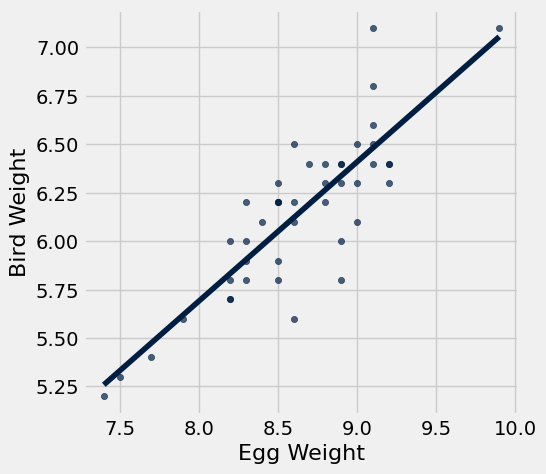

In [6]:
# Just run this cell and examine the scatter plot.
birds.scatter('Egg Weight', "Bird Weight", fit_line=True)

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## 1. Finding the Bootstrap Confidence Interval for the True Slope

Looking at the scatter plot of our sample, we observe a linear relationship between egg weight and bird weight. However, relationships that appear in a sample might not exist in the population from which the sample was taken.

We want to know if there truly exists a linear relationship between egg weight and bird weight for Snowy Plovers. If there is no linear relationship between the two variables, then we'd expect a correlation of 0. Consequently, the slope of the regression line would also be 0. 

We highly recommend reviewing section [16.2](https://inferentialthinking.com/chapters/16/2/Inference_for_the_True_Slope.html) before attempting this part of the homework

<!-- BEGIN QUESTION -->

---

**Question 1.1.** Let's run a hypothesis test using confidence intervals to see if there is a linear relationship between egg weight and bird weight. Define the null and alternative hypotheses that will allow you to conduct this test. **(8 points)**

*Note:* Please write your answer **in the cell below** in the following format:
- **Null Hypothesis:**
- **Alternative Hypothesis:**

> **Hint:** Reminder your null hypothesis should be about the relationship in the population. 

* Null Hypothesis: the slope of true line is 0
* Alternative Hypothesis: the slope of true line is not 0

<!-- END QUESTION -->

---

**Question 1.2.** Define the following two functions:

1. `standard_units`: This function takes in an array of numbers and returns an array containing those numbers converted to standard units.
2. `correlation`: This function takes in a table and two column names (one for *x* and one for *y*) and returns the correlation between these columns. 

**(4 points)**


In [10]:
def standard_units(arr):
    return (arr - np.mean(arr)) / np.std(arr)

def correlation(tbl, x_col, y_col):
    return np.mean(standard_units(tbl.column(x_col)) * standard_units(tbl.column(y_col)))

In [11]:
grader.check("q1_2")

q1_2 results: All test cases passed!

---

**Question 1.3.** Using the functions you just implemented, create a function called `fit_line`.  It should take a table (e.g. `birds`) and the column names associated to *x* and *y* as its arguments and return an *array* containing the slope and intercept of the regression line (in that order) that predicts the *y* column in the table using the *x* column. **(8 points)**


In [12]:
def fit_line(tbl, x_col, y_col):
    r = correlation(tbl, x_col, y_col)
    x_mean = np.mean(tbl.column(x_col))
    x_std = np.std(tbl.column(x_col))
    y_mean = np.mean(tbl.column(y_col))
    y_std = np.std(tbl.column(y_col))
    slope = r * y_std / x_std
    intercept = y_mean - slope * x_mean
    return make_array(slope, intercept)

fit_line(birds, "Egg Weight", "Bird Weight")

array([ 0.71851534, -0.05827226])

In [13]:
grader.check("q1_3")

q1_3 results: All test cases passed!

**Run** this cell to plot the line produced by calling `fit_line` on the `birds` table.  

**Note:** You are not responsible for the code in the cell below, but make sure that your `fit_line` function generated a reasonable line for the data.

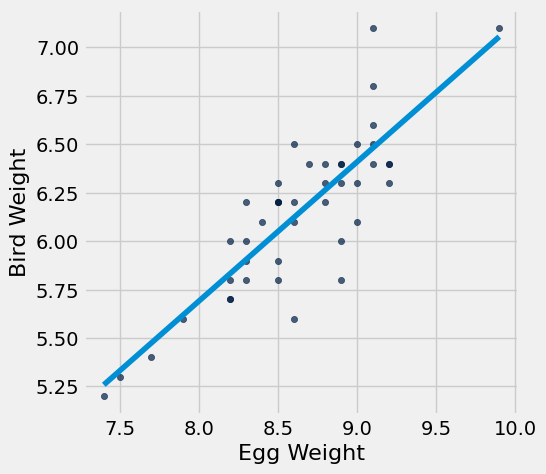

In [14]:
# Ensure your fit_line function fits a reasonable line 
# to the data in birds, using the plot below.

# Just run this cell
sample_slope, sample_intercept = fit_line(birds, "Egg Weight", "Bird Weight")
birds.scatter("Egg Weight", "Bird Weight")
plt.plot([min(birds.column("Egg Weight")), max(birds.column("Egg Weight"))], 
         [sample_slope*min(birds.column("Egg Weight"))+sample_intercept, sample_slope*max(birds.column("Egg Weight"))+sample_intercept])
plt.show()

Now we have all the tools we need to create a confidence interval that quantifies our uncertainty about the true relationship between egg weight and bird weight.

<!-- BEGIN QUESTION -->

---

**Question 1.4.** Create an array called `resampled_slopes` that contains the slope of the best fit line for 1000 bootstrap resamples of `birds`. Plot the distribution of these slopes. **(8 points)**

In [15]:
birds.labels

('Egg Length', 'Egg Breadth', 'Egg Weight', 'Bird Weight')

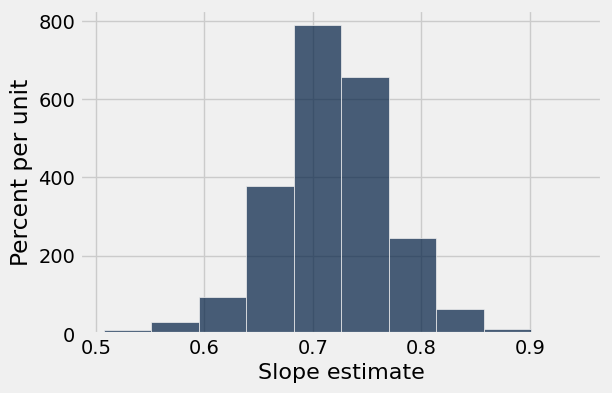

In [17]:
resampled_slopes = make_array()

for i in np.arange(1000): 
    birds_bootstrap = birds.sample(birds.num_rows, with_replacement=True)
    bootstrap_line = fit_line(birds_bootstrap, 'Egg Weight', 'Bird Weight')
    bootstrap_slope = bootstrap_line[0]
    resampled_slopes = np.append(resampled_slopes, bootstrap_slope)
    
# DO NOT CHANGE THIS LINE
Table().with_column("Slope estimate", resampled_slopes).hist()

In [18]:
grader.check("q1_4")

q1_4 results: All test cases passed!

<!-- END QUESTION -->

---

**Question 1.5.** Use your resampled slopes to construct an 95% confidence interval for the true value of the slope. **(8 points)**

In [19]:
lower_end = percentile(2.5, resampled_slopes)
upper_end = percentile(97.5, resampled_slopes)
print("95% confidence interval for slope: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for slope: [0.608042, 0.822845]


In [20]:
grader.check("q1_5")

q1_5 results: All test cases passed!

<!-- BEGIN QUESTION -->

---

**Question 1.6.** Based on your confidence interval, would you reject or fail to reject the null hypothesis that the true slope is 0?  Why?  What p-value cutoff are you using? **(8 points)**

*Hint*: Read [the introduction](#intro) of this homework!

Reject the null hypothesis with p-value cutoff = 5%

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---

**Question 1.7.** Using your results from previous questions, **provide an estimated range for the true slope**. How confident are you that the true slope falls within this range? **(8 points)**

95% for [lower bound, upper bound]

<!-- END QUESTION -->

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## 2. Finding the Bootstrap Prediction Interval

Suppose we're visiting Point Reyes and stumble upon some Snowy Plover eggs; we'd like to know how heavy they'll be once they hatch. In other words, we want to use our regression line to make predictions about a bird's weight based on the weight of the corresponding egg.

However, just as we're uncertain about the slope of the true regression line, we're also uncertain about the predictions made based on the true regression line.

---

**Question 2.1.** Define the function `fitted_value`.  It should take in four arguments:

1. `table`: a table like `birds`.  We'll be predicting the values in the second column using the first.
2. `x_col`: the name of our x-column within the input `table`
3. `y_col`: the name of our y-column within the input `table`
2. `given_x`: a number, the value of the predictor variable for which we'd like to make a prediction.
  
The function should return the line’s prediction for the given x. **(6 points)**

*Hint:* Make sure to use the `fit_line` function you defined in Question 1.3.


In [21]:
def fitted_value(table, x_col, y_col, given_x):
    line = fit_line(table, x_col, y_col)
    slope = line[0]
    intercept = line[1]
    return slope * given_x + intercept

# Here's an example of how fitted_value is used. The code below
# computes the prediction for the bird weight, in grams, based on
# an egg weight of 8 grams.
egg_weight_eight = fitted_value(birds, "Egg Weight", "Bird Weight", 8)
egg_weight_eight

5.6898504972151462

In [22]:
grader.check("q2_1")

q2_1 results: All test cases passed!

---

**Question 2.2.** Raymond, the resident Snowy Plover expert at Point Reyes, tells us that the egg he has been carefully observing has a weight of 9 grams. Using `fitted_value` above, assign the variable `experts_egg` to the predicted bird weight for Raymond's egg. **(4 points)**


In [26]:
experts_egg = fitted_value(birds, 'Egg Weight', 'Bird Weight', 9)
experts_egg

6.4083658421088252

In [27]:
grader.check("q2_2")

q2_2 results: All test cases passed!

In [28]:
# Let's look at the number of rows in the birds table.
birds.num_rows

44

A fellow parkgoer raises the following objection to your prediction:

> "Your prediction depends on your sample of 44 birds.  Wouldn't your prediction change if you had a different sample of 44 birds?"

Having read section [16.3](https://inferentialthinking.com/chapters/16/3/Prediction_Intervals.html) of the textbook, you know just the response! Had the sample been different, the regression line would have been different too. This would ultimately result in a different prediction. To see how good our prediction is, we must get a sense of how variable the prediction can be.

---

**Question 2.3.** Define a function `compute_resampled_line` that takes in a table `tbl`and two column names, `x_col` and `y_col`, and returns an array containing the parameters of the best fit line (slope and intercept) for one bootstrapped resample of the table. **(6 points)**


In [29]:
def compute_resampled_line(tbl, x_col, y_col):
    resample = tbl.sample(tbl.num_rows, with_replacement=True)
    resampled_line = fit_line(resample, x_col, y_col)
    return resampled_line

In [30]:
grader.check("q2_3")

q2_3 results: All test cases passed!

**Run** the following cell below in order to define the function `bootstrap_lines`.  It takes in four arguments:
1. `tbl`: a table like `birds`
2. `x_col`: the name of our x-column within the input `tbl`
3. `y_col`: the name of our y-column within the input `tbl`
4. `num_bootstraps`: an integer, a number of bootstraps to run.

It returns a *table* with one row for each bootstrap resample and the following two columns:
1. `Slope`: the bootstrapped slopes 
2. `Intercept`: the corresponding bootstrapped intercepts 

In [31]:
# Just run this cell
def bootstrap_lines(tbl, x_col, y_col, num_bootstraps):
    resampled_slopes = make_array()
    resampled_intercepts = make_array() 
    for i in np.arange(num_bootstraps): 
        resampled_line = compute_resampled_line(tbl, x_col, y_col) 
        resampled_slope = resampled_line.item(0) 
        resampled_intercept = resampled_line.item(1) 
        resampled_slopes = np.append(resampled_slopes,resampled_slope)
        resampled_intercepts = np.append(resampled_intercepts,resampled_intercept)
    tbl_lines = Table().with_columns('Slope', resampled_slopes, 'Intercept', resampled_intercepts)
    return tbl_lines

regression_lines = bootstrap_lines(birds, "Egg Weight", "Bird Weight", 1000)
regression_lines

Slope,Intercept
0.710651,0.0137041
0.708569,0.0737971
0.687164,0.270985
0.600751,0.928525
0.728061,-0.130527
0.66323,0.391634
0.630949,0.683036
0.770041,-0.456869
0.732188,-0.167638
0.675155,0.315308


<!-- BEGIN QUESTION -->

---

**Question 2.4.** Create an array called `predictions_for_eight` that contains the predicted bird weights based on an egg of weight 8 grams for each regression line in `regression_lines`. **(6 points)**

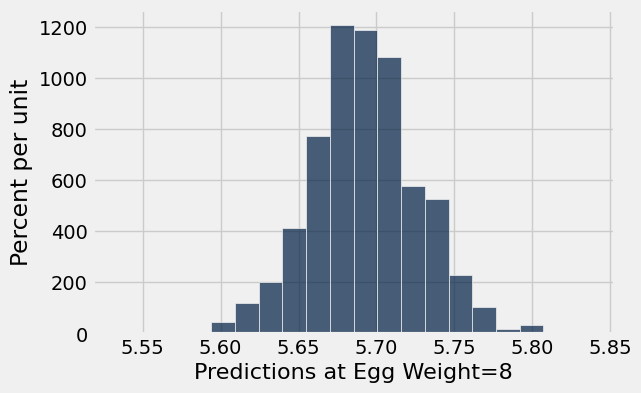

In [32]:
predictions_for_eight = 8 * regression_lines.column('Slope') + regression_lines.column('Intercept')

# This will make a histogram of your predictions:
table_of_predictions = Table().with_column('Predictions at Egg Weight=8', predictions_for_eight)
table_of_predictions.hist('Predictions at Egg Weight=8', bins=20)

In [33]:
grader.check("q2_4")

q2_4 results: All test cases passed!

<!-- END QUESTION -->

---

**Question 2.5.** Create an approximate 95% confidence interval for these predictions. **(6 points)**

In [34]:
lower_bound = percentile(2.5, predictions_for_eight)
upper_bound = percentile(97.5, predictions_for_eight)

print('95% Confidence interval for predictions for x=8: (', lower_bound,",", upper_bound, ')')

95% Confidence interval for predictions for x=8: ( 5.62208258528 , 5.76244444444 )


In [35]:
grader.check("q2_5")

q2_5 results: All test cases passed!

---

**Question 2.6.** Set `plover_statements` to an array of integer(s) that correspond to statement(s) that are true. **(6 points)**

1. The 95% confidence interval covers 95% of the bird weights for eggs that had a weight of eight grams in `birds`.

2. The 95% confidence interval gives a sense of how much actual weights differ from your prediction.

3. The 95% confidence interval quantifies the uncertainty in our estimate of what the true line would predict.

In [38]:
plover_statements = make_array(3)

In [39]:
grader.check("q2_6")

q2_6 results: All test cases passed!

## Pets of Data 8

Alright, Data 8 students, here’s some wisdom for _studying_. You should take breaks and pet **ONLY** cats —oh, wait, how did this camera flip? Forget what I said, I’m just…a regular human with paws… I mean hands!

<img src="./cagney.jpeg" width="40%" alt="some cat taking a casual selfie"/>

**Cagney** is happy you finished homework 11!

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Written Work Submission

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. You are responsible for submitting both the coding portion (the zip) and the written portion (the PDF) to their respective Gradescope portals. **Please save before exporting!**

> **Important: You must correctly assign the pages of your PDF after you submit to the correct gradescope assignment. If your pages are not correctly assigned and/or not in the correct PDF format by the deadline, we reserve the right to award no points for your written work.**

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> Webpdf`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit one single PDF of your screenshots. Either way, **you are responsible for ensuring your submision follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

**You must submit the PDF generated via one of these methods, we will not accept screenshots or Word documents.**

In [40]:
# from otter.export import export_notebook
# from os import path
# from IPython.display import display, HTML
# name = 'hw11'
# export_notebook(f"{name}.ipynb", filtering=True, pagebreaks=True)
# if(path.exists(f'{name}.pdf')):
#     display(HTML(f"Download your PDF <a href='{name}.pdf' download>here</a>."))
# else:
#     print("\n Pdf generation failed, please try the other methods described above")

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [41]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q0_1 results: All test cases passed!

    q1_2 results: All test cases passed!

    q1_3 results: All test cases passed!

    q1_4 results: All test cases passed!

    q1_5 results: All test cases passed!

    q2_1 results: All test cases passed!

    q2_2 results: All test cases passed!

    q2_3 results: All test cases passed!

    q2_4 results: All test cases passed!

    q2_5 results: All test cases passed!

    q2_6 results: All test cases passed!
